# Tutorial 8 - Graph Neural Network for PDE

In this tutorial, we will learn how to use Graph Neural Networks (GNNs) to solve Partial Differential Equations (PDEs). Simply, we will work with structured Allen-Cahn equation.

In [15]:
import torch.nn as nn
import torch

import random
import h5py
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset

import matplotlib.pyplot as plt

from torch.optim import AdamW

torch.manual_seed(0)
np.random.seed(0)
random.seed(0)

Text(0.5, 1.0, 'Output')

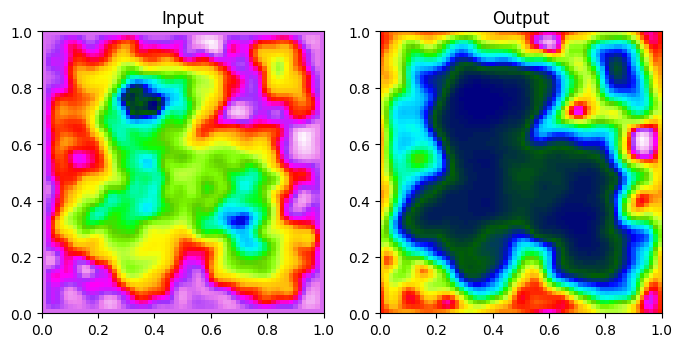

In [16]:
########################
# Dataloader definition:
########################

class AllenCahnDataset(Dataset):
    def __init__(self, which="train", training_samples = 256):

        assert training_samples<=256

        #Default file:
        self.file_data = "AISE_ex_7_data.h5"
        self.reader = h5py.File(self.file_data, 'r')

        #Load normaliation constants:
        self.min_data = self.reader['min_u0'][()]
        self.max_data = self.reader['max_u0'][()]
        self.min_model = self.reader['min_u'][()]
        self.max_model = self.reader['max_u'][()]

        if which == "train":
            self.length = training_samples
            self.start = 0
        elif which == "val":
            self.length = 128
            self.start = 256
        elif which == "test":
            self.length = 128
            self.start = 256+128

        self.reader = h5py.File(self.file_data, 'r')

    def __len__(self):
        return self.length

    def __getitem__(self, index):
        inputs = torch.from_numpy(self.reader['Sample_' + str(index + self.start)]["input"][:]).type(torch.float32).reshape(1, 64, 64)
        labels = torch.from_numpy(self.reader['Sample_' + str(index + self.start)]["output"][:]).type(torch.float32).reshape(1, 64, 64)

        inputs = (inputs - self.min_data)/(self.max_data - self.min_data)
        labels = (labels - self.min_model)/(self.max_model - self.min_model)

        return inputs, labels

training_samples = 256
batch_size = 16

train_dataset = AllenCahnDataset(which="train", training_samples = training_samples)
val_dataset = AllenCahnDataset(which="val")

train_loader  = DataLoader(train_dataset, batch_size = batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size = batch_size, shuffle=False)


input, output = next(iter(train_loader))
input = input[0,0].numpy()
output = output[0,0].numpy()

fig, axes = plt.subplots(1, 2, figsize=(8, 4))
axes[0].imshow(input, cmap = "gist_ncar", extent=(0,1,0,1),)
axes[0].set_title("Input")
axes[1].imshow(output, cmap = "gist_ncar", extent=(0,1,0,1),)
axes[1].set_title("Output")

In [17]:
"""
This file contains the models for the GNN-based models.
"""
import torch
import copy
#from torch_scatter import scatter
from typing import Optional
import torch.nn as nn
import torch.nn.functional as F
import torch_geometric.nn as gnn
from torch_geometric.nn import GCNConv, GATConv


##########Utility Functions##########

class Activation(nn.Module):
    """
        Parameters:
        -----------
            x: torch.FloatTensor
                input tensor
        Returns:
        --------
            y: torch.FloatTensor
                output tensor, same shape as the input tensor, since it's element-wise operation
    """
    def __init__(self, activation:str):
        super().__init__()
        activation = activation.lower() # prevent potential typo
        if activation in ['sigmoid', 'tanh']:
            # prevent potential warning message
            self.activation_fn = getattr(torch, activation)
        elif activation == "swish":
            self.beta = nn.Parameter(torch.ones(1), requires_grad=True)

        elif activation == "identity":
            self.activation_fn = lambda x: x
        else:
            self.activation_fn = getattr(F, activation)
        self.activation = activation
    def forward(self, x):
        if self.activation == "swish":
            return x * torch.sigmoid(self.beta * x)
        elif self.activation == "gelu":
            return x * torch.sigmoid(1.702 * x)
        elif self.activation == "mish":
            return x * torch.tanh(F.softplus(x))
        else:
            return self.activation_fn(x)

class MLP(nn.Module):
    """MLP with configurable number of layers and activation function

        Parameters:
        -----------
            x: torch.FloatTensor
                node features [num_nodes, num_features]
        Returns:
        --------
            y: torch.FloatTensor
                node labels [num_nodes, num_classes]
    """
    def __init__(self, num_features, num_classes,
        num_hidden=64, num_layers=3, activation="relu", input_dropout=0., dropout=0., bn=False, res=False):
        super().__init__()
        self.layers     = nn.ModuleList([nn.Linear(num_features, num_hidden)])
        for i in range(num_layers-2):
            self.layers.append(nn.Linear(num_hidden, num_hidden))
        self.layers.append(nn.Linear(num_hidden, num_classes))
        self.activation = Activation(activation)
        self.input_dropout    = nn.Dropout(input_dropout) if input_dropout > 0 else Identity()
        self.dropout          = nn.Dropout(dropout) if dropout > 0 else Identity()
        if bn:
            self.bns = nn.ModuleList([nn.BatchNorm1d(num_features)])
            for i in range(num_layers-2):
                self.bns.append(nn.BatchNorm1d(num_hidden))
            self.bns.append(nn.BatchNorm1d(num_hidden))
        else:
            self.bns = None
        if res:
            self.linear = nn.Linear(num_features, num_classes)
        else:
            self.linear = None
        self.num_features = num_features
        self.num_classes  = num_classes
        self.reset_parameters()
    def reset_parameters(self):
        for layer in self.layers:
            layer.reset_parameters()
        if self.bns is not None:
            for bn in self.bns:
                bn.reset_parameters()
    def forward(self, x):
        input = x
        x = self.input_dropout(x)
        x = self.bns[0](x) if self.bns is not None else x
        for i,layer in enumerate(self.layers[:-1]):
            x = layer(x)
            x = self.activation(x)
            x = self.dropout(x)
            x = self.bns[i](x) if self.bns is not None else x
        x = self.layers[-1](x)
        if self.linear is not None:
            x = x + self.linear(input)
        return x

class Identity(nn.Module):
    def forward(self, x):
        return x

#---------------------------------#

def init_gnn_model(model, num_features, num_classes, kwargs):
    if model == "gcn":
        return GCN(num_features, num_classes, num_hidden=kwargs.n_hidden, num_layers=kwargs.n_layers, activation=kwargs.activation)
    elif model == "gat":
        return GAT(num_features, num_classes, num_hidden=kwargs.n_hidden, num_layers=kwargs.n_layers, num_heads=kwargs.num_heads, activation=kwargs.activation)
    elif model == "sign":
        return SIGN(num_features, num_classes, num_hidden=kwargs.n_hidden, num_layers=kwargs.n_layers, num_hops=kwargs.num_hops, activation=kwargs.activation)
    elif model == "mpnp":
        return MPNP(num_features, num_classes, num_hidden=kwargs.n_hidden, num_mp_layers=kwargs.num_mp_layers, activation=kwargs.activation)
    else:
        raise NotImplementedError(f"Unknown model {model}")


class IN(gnn.MessagePassing):
    """
    Interaction Network (IN) - Single Message Passing Layer

    Components:
    - Edge Update Function (message_net): computes messages on edges
    - Node Update Function (node_update_net): updates node features
    """
    def __init__(self, num_features, num_classes, num_hidden=64, activation="relu",
                 edge_hidden=64, node_hidden=64):
        super().__init__(aggr='mean')

        # Edge Update Function: computes messages from edge features
        # Input: [x_i, x_j] (concatenated source and target node features)
        # Output: message of dimension edge_hidden
        self.edge_update_net = nn.Sequential(
            nn.Linear(2 * num_features, edge_hidden),
            nn.Linear(edge_hidden, edge_hidden)
        )

        # Node Update Function: updates node features using aggregated messages
        # Input: [x, aggregated_message] (node feature + aggregated neighbor messages)
        # Output: updated node features of dimension num_classes
        self.node_update_net = nn.Sequential(
            nn.Linear(num_features + edge_hidden, node_hidden),
            nn.Linear(node_hidden, num_classes)
        )

        self.activation = Activation(activation)
        self.norm = nn.InstanceNorm1d(num_features)
        self.num_features = num_features
        self.num_classes = num_classes
        self.reset_parameters()

    def reset_parameters(self):
        for module in self.edge_update_net:
            module.reset_parameters()
        for module in self.node_update_net:
            module.reset_parameters()
        self.norm.reset_parameters()

    def forward(self, x, edge_index):
        x = self.propagate(edge_index, x=x)
        x = self.norm(x.permute(0,2,1)).permute(0,2,1)
        return x

    def message(self, x_i: torch.Tensor , x_j: torch.Tensor) -> torch.Tensor:
        """
        Edge Update Function: compute messages on edges
        Args:
            x_i: target node features
            x_j: source node features
        Returns:
            message: computed edge messages
        """
        message = self.edge_update_net[0](torch.cat([x_i, x_j], dim=-1))
        message = self.activation(message)
        message = self.edge_update_net[1](message)
        message = self.activation(message)
        return message

    def update(self, message: torch.Tensor, x: torch.Tensor) -> torch.Tensor:
        """
        Node Update Function: update node features using aggregated messages
        Args:
            message: aggregated messages from neighbors
            x: current node features
        Returns:
            updated node features
        """
        update = self.node_update_net[0](torch.cat([x, message], dim=-1))
        update = self.activation(update)
        update = self.node_update_net[1](update)
        update = self.activation(update)

        if self.num_features == self.num_classes:
            update = update + x  # Residual connection
        return update


class MPNP(nn.Module):
    """
    Message Passing Neural PDE (MPNP)

    Stacks multiple Interaction Network (IN) layers to perform
    multiple rounds of message passing.

    Args:
        num_features: input feature dimension
        num_classes: output feature dimension
        num_hidden: hidden feature dimension
        num_mp_layers: number of message passing layers (stacked IN layers)
        activation: activation function
    """
    def __init__(self, num_features, num_classes,
                 num_hidden=64, num_mp_layers=3, activation="relu"):
        super().__init__()

        # Message Passing Layers: stack multiple IN layers
        self.mp_layers = nn.ModuleList()

        self.mp_layers.append(IN(num_features, num_hidden, num_hidden, activation))
        for i in range(num_mp_layers - 2):
            self.mp_layers.append(IN(num_hidden, num_hidden, num_hidden, activation))
        self.mp_layers.append(IN(num_hidden, num_classes, num_hidden, activation))

        self.num_features = num_features
        self.num_classes = num_classes
        self.num_mp_layers = num_mp_layers
        self.reset_parameters()

    def reset_parameters(self):
        for layer in self.mp_layers:
            layer.reset_parameters()

    def forward(self, x, edge_index):
        """
        Forward pass: apply message passing layers sequentially
        """
        for layer in self.mp_layers:
            x = layer(x, edge_index)
        return x


class GCN(nn.Module):
    def __init__(self, num_features, num_classes,
        num_hidden  = 64, num_layers  = 3, activation  = "relu"):
        super().__init__()
        self.layers     = nn.ModuleList([GCNConv(num_features, num_hidden)])
        for i in range(num_layers-2):
            self.layers.append(GCNConv(num_hidden, num_hidden))
        self.layers.append(GCNConv(num_hidden, num_classes))
        self.activation = Activation(activation)
        self.num_features = num_features
        self.num_classes  = num_classes
        self.reset_parameters()

    def reset_parameters(self):
        for layer in self.layers:
            layer.reset_parameters()

    def forward(self, x, edge_index):
        for layer in self.layers[:-1]:
            x = self.activation(layer(x, edge_index))
        x = self.layers[-1](x, edge_index)
        return x


class GAT(nn.Module):
    def __init__(self, num_features, num_classes,
        num_hidden  = 64, num_layers  = 3, num_heads=4, activation  = "relu"):
        super().__init__()
        self.layers     = nn.ModuleList([GATConv(num_features, num_hidden//num_heads, heads=num_heads)])
        for i in range(num_layers-2):
            self.layers.append(GATConv(num_hidden, num_hidden//num_heads, heads=num_heads))
        # self.layers.append(GATConv(num_hidden, num_classes, num_heads=1))
        self.layers.append(GATConv(num_hidden, num_classes, heads=1))
        self.activation = Activation(activation)
        self.num_features = num_features
        self.num_classes  = num_classes
        self.reset_parameters()

    def reset_parameters(self):
        for layer in self.layers:
            layer.reset_parameters()

    def forward(self, x, edge_index):
        xs = []
        for i in range(x.shape[0]):
            x_i = x[i]
            for layer in self.layers[:-1]:
                x_i = self.activation(layer(x_i, edge_index))
            x_i = self.layers[-1](x_i, edge_index)
            xs.append(x_i)
        x = torch.stack(xs, dim=0)

        return x


class SIGN(nn.Module):
    def __init__(self, num_features, num_classes,
        num_hidden = 64, num_layers = 3, num_hops=3, activation = "relu"):
        super().__init__()
        self.props   = nn.ModuleList([gnn.SGConv(num_features, num_hidden, K=k) for k in range(1,num_hops+1)])
        self.braches = nn.ModuleList(
            [MLP(num_features, num_hidden, num_hidden, num_layers, activation, res=True)]+
            [MLP(num_hidden, num_hidden, num_hidden, num_layers-1, activation, res=True) for _ in range(num_hops)])
        self.merger  = MLP(num_hidden*(num_hops + 1), num_classes, num_hidden, num_layers, activation)
        self.num_features = num_features
        self.num_classes  = num_classes
        self.reset_parameters()
    def reset_parameters(self):
        for prop, branch in zip(self.props, self.braches):
            prop.reset_parameters()
            branch.reset_parameters()
        self.merger.reset_parameters()

    def forward(self, x, edge_index):
        """
            Parameters:
            -----------
                x: torch.FloatTensor [..., n_node, n_feature]
            Returns:
            --------
                y: torch.FloatTensor [..., n_node, n_class]
        """
        props = [x] + [prop(x, edge_index) for prop in self.props]
        branches = [branch(prop) for prop, branch in zip(props, self.braches)]
        x = torch.cat(branches, dim=-1)
        x = self.merger(x)
        return x

ModuleNotFoundError: No module named 'torch_geometric'

In [ ]:
import torch

def format_pytorch_version(version):
  return version.split('+')[0]

TORCH_version = torch.__version__
TORCH_version = format_pytorch_version(TORCH_version)

print(f"Installing torch-geometric with torch=={TORCH_version}...")
!pip install torch-scatter -f https://data.pyg.org/whl/torch-{TORCH_version}.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-{TORCH_version}.html
!pip install torch-cluster -f https://data.pyg.org/whl/torch-{TORCH_version}.html
!pip install torch-spline-conv -f https://data.pyg.org/whl/torch-{TORCH_version}.html
!pip install torch-geometric

# Restart runtime after installation
import os
os.kill(os.getpid(), 9)

Installing torch-geometric with torch==2.8.0...
Looking in links: https://data.pyg.org/whl/torch-2.8.0.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.0/108.0 kB 3.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for torch-scatter: filename=torch_scatter-2.1.2-cp312-cp312-linux_x86_64.whl size=640889 sha256=a2ae66b300a3ef1b6991e73c11895aad53cb720e03a7c525f2c9216d1e34558b
  Stored in directory: /root/.cache/pip/wheels/84/20/50/44800723f57cd798630e77b3ec83bc80bd26a1e3dc3a672ef5
Successfully built torch-scatter
Looking in links: https://data.pyg.org/whl/torch-2.8.0.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.0/210.0 kB 5.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for torch-sparse: filename=torch_sparse-0.6.18-cp312-cp312-linux_x86_64.whl size=1158903 sha256=df26c898679f0cb6884d2d7fbae2a5af494cd2bdb5b527a8cd7dec7918a86a90
  Stored in directory: /root/.cache/pip/wheels/71/fa/21/bd1d78ce1629aec4ecc924a63b82f6949dda48

In [ ]:
## Define Graph Structure and Initialize Model

########################
# Model definition:
########################

# from models import init_gnn_model
import torch_geometric
from torch_geometric.data import Data

def create_grid_graph(height=64, width=64):
    """
    Create a grid graph structure from image dimensions.
    Each pixel is a node, connected to its 4 neighbors (up, down, left, right).

    Returns:
        edge_index: torch.LongTensor of shape [2, num_edges]
    """
    edges = []

    # Create edges for grid connectivity (4-neighbors)
    for i in range(height):
        for j in range(width):
            node_idx = i * width + j

            # Connect to right neighbor
            if j < width - 1:
                edges.append([node_idx, node_idx + 1])
                edges.append([node_idx + 1, node_idx])

            # Connect to bottom neighbor
            if i < height - 1:
                edges.append([node_idx, node_idx + width])
                edges.append([node_idx + width, node_idx])

    edge_index = torch.LongTensor(edges).t().contiguous()
    return edge_index

# Create the graph structure (this is fixed for all samples)
edge_index = create_grid_graph(64, 64)


# Initialize model using init_gnn_model function
class Config:
    def __init__(self):
        self.n_hidden = 64          # hidden dimension
        self.n_layers = 4           # number of GNN layers (for GCN, GAT, SIGN)
        self.activation = "gelu"    # activation function

        # Model-specific parameters:
        self.num_heads = 4          # for GAT model
        self.num_hops = 3           # for SIGN model
        self.num_mp_layers = 4      # for MPNP model: number of message passing layers

config = Config()

# You can try different models: "gcn", "gat", "mpnp", "sign"
model_name = "gcn"
model = init_gnn_model(
    model=model_name,
    num_features=1,  # input has 1 channel
    num_classes=1,   # output has 1 channel
    kwargs=config
)

print(f"Model initialized: {model.__class__.__name__}")
print(f"Number of parameters: {sum(p.numel() for p in model.parameters())}")

In [ ]:
########################
# Training loop:
########################
optimizer = AdamW(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0 = 200, eta_min=10**-6)
l = nn.L1Loss()

num_epochs = 20

freq_print = 1
for epoch in range(num_epochs):
    model.train()
    train_mse = 0.0
    for step, (input_batch, output_batch) in enumerate(train_loader):
        # Reshape from [batch, 1, 64, 64] to [batch, 64*64, 1] for graph processing
        batch_size = input_batch.shape[0]
        input_nodes = input_batch.reshape(batch_size, 64*64, 1)
        output_nodes = output_batch.reshape(batch_size, 64*64, 1)

        optimizer.zero_grad()
        output_pred_nodes = model(input_nodes, edge_index)

        # Reshape back for loss computation
        output_pred_batch = output_pred_nodes.reshape(batch_size, 1, 64, 64)

        loss_f = l(output_pred_batch, output_batch) / l(output_batch, torch.zeros_like(output_batch))
        loss_f.backward()
        optimizer.step()
        train_mse += loss_f.item()
    train_mse /= len(train_loader)

    scheduler.step()
    with torch.no_grad():
        model.eval()
        test_relative_l1 = 0.0
        for step, (input_batch, output_batch) in enumerate(val_loader):
            # Reshape from [batch, 1, 64, 64] to [batch, 64*64, 1]
            batch_size = input_batch.shape[0]
            input_nodes = input_batch.reshape(batch_size, 64*64, 1)
            output_nodes = output_batch.reshape(batch_size, 64*64, 1)

            output_pred_nodes = model(input_nodes, edge_index)
            output_pred_batch = output_pred_nodes.reshape(batch_size, 1, 64, 64)

            loss_f = (torch.mean((abs(output_pred_batch - output_batch))) / torch.mean(abs(output_batch))) * 100
            test_relative_l1 += loss_f.item()
        test_relative_l1 /= len(val_loader)

    if epoch % freq_print == 0: print("## Epoch:", epoch, " ## Train Loss:", train_mse, "## Rel L1 Test Norm:", test_relative_l1, "LR: ", scheduler.get_last_lr())

In [ ]:
########################
# Plot results:
########################
model.eval()
with torch.no_grad():
    input, output = next(iter(val_loader))

    # Reshape for graph model
    batch_size = input.shape[0]
    input_nodes = input.reshape(batch_size, 64*64, 1)
    pred_nodes = model(input_nodes, edge_index)
    pred = pred_nodes.reshape(batch_size, 1, 64, 64)

    # Convert to numpy for visualization
    input = input[0,0].numpy()
    output = output[0,0].numpy()
    pred = pred[0,0].detach().numpy()

vmin = np.min(output)
vmax = np.max(output)

fig, axes = plt.subplots(1, 3, figsize=(12, 4))
axes[0].imshow(input, cmap = "gist_ncar", extent=(0,1,0,1),)
axes[0].set_title("Input")
axes[1].imshow(output, cmap = "gist_ncar", extent=(0,1,0,1), vmin = vmin, vmax= vmax)
axes[1].set_title("Ground Truth")
axes[2].imshow(pred, cmap = "gist_ncar", extent=(0,1,0,1), vmin = vmin, vmax= vmax)
axes[2].set_title("Prediction")
plt.tight_layout()
plt.show()